In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import numpy as np
from numpy.random import normal, multivariate_normal
import P_binary
import P_random
import P_posterior
from astropy.table import Table
import pickle
import time
import corner

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
print "Opening Tycho-2 catalog..."
# Read in sample from Tycho-2 table
filename = ('../data/tycho-2/tyc2.dat')
readme = ('../data/tycho-2/ReadMe')
tycho_full = Table.read(filename, format='cds', guess=False, readme=readme)
print "...finished reading data."


# Create the clean tycho-2 catalog
dtype = [('ID','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('Bmag','f8'),('Vmag','f8')]

ids = np.intersect1d(np.where(tycho_full['q_pmRA'] >= 0.1), np.where(tycho_full['q_pmDE'] >= 0.1))

t = np.zeros(len(ids), dtype=dtype)
t['ID'] = tycho_full['TYC1'][ids]*100000 + tycho_full['TYC2'][ids]
t['ra'] = tycho_full['RAmdeg'][ids]
t['dec'] = tycho_full['DEmdeg'][ids]
t['mu_ra'] = tycho_full['pmRA'][ids]
t['mu_dec'] = tycho_full['pmDE'][ids]
t['mu_ra_err'] = tycho_full['e_pmRA'][ids]
t['mu_dec_err'] = tycho_full['e_pmDE'][ids]
t['Bmag'] = tycho_full['BTmag'][ids]
t['Vmag'] = tycho_full['VTmag'][ids]


Opening Tycho-2 catalog...
...finished reading data.


In [3]:
# Generate simulated binaries
print "Generating binaries..."
P_binary.generate_binary_set(num_sys=100000)

Generating binaries...


In [4]:
# Generate random alignment KDEs using first entry as a test position
pos_density = P_random.get_sigma_pos(t['ra'][0], t['dec'][0], catalog=t, method='kde')
pm_density = P_random.get_sigma_mu(t['mu_ra'][0], t['mu_dec'][0], catalog=t, method='kde')

In [5]:
def get_ang_sep(ra1, dec1, ra2, dec2):
    rad_dec1 = np.pi/180.0 * dec1
    rad_dec2 = np.pi/180.0 * dec2
    return np.sqrt( (ra1-ra2)**2 * np.cos(rad_dec1) * np.cos(rad_dec2) + (dec1-dec2)**2 )

In [25]:
size_integrate = 10  # Number of samples for delta mu integration
size_integrate_full = 10000
f_bin = 0.5  # binary fraction

start = time.time()

# Now, let's calculate the probabilities
length = len(t)
print "We are testing", length, "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('ID_1','i4'),('ID_2','i4'),('P_random','f8'),('P_binary','f8'),('P_posterior','f8')]
prob_out = np.array([], dtype=dtype)


for i in np.arange(length):
    
    # if i%1000 == 0: print i
    print i
    
    if i%10 == 0 and i != 0: break
    
    # Get ids of all stars within 1 degree
    i_star2 = np.arange(length - i - 1) + i + 1
    theta = get_ang_sep(t['ra'][i], t['dec'][i], t['ra'][i_star2], t['dec'][i_star2])
    ids_good = i_star2[np.where(theta < 1.0)[0]]
    
    
#     print np.where(theta < 1.0)[0]
#     print i_star2[np.where(theta < 1.0)[0]][0], ids_good[0]
#     print t['ra'][i], t['dec'][i], t['ra'][ids_good[0]], t['dec'][ids_good[0]], theta[ids_good[0]-i-1]
#     If a repeated entry, move on to the next one
#     if np.any(t['ID'][i] == t['ID'][ids_good]): continue
    

    

#     print i, t['ID'][i], len(ids_good), np.min(theta)*3600.0, t['ra'][i], t['dec'][i], t['ra'][np.argmin(theta)+i+1], t['dec'][np.argmin(theta)+i+1]
#     tmp_i = ids_good[np.argmin(theta[ids_good])] 
#     print i, tmp_i, t['ID'][tmp_i], t['ra'][tmp_i], t['dec'][tmp_i]
    
    
    # Move on if no matches within 1 degree
    if len(ids_good) == 0: continue
    
    delta_mu_ra_err = np.sqrt(t['mu_ra_err'][i]**2 + t['mu_ra_err'][ids_good]**2)
    delta_mu_dec_err = np.sqrt(t['mu_dec_err'][i]**2 + t['mu_dec_err'][ids_good]**2)

    
    delta_mu_ra_sample = multivariate_normal(mean=(t['mu_ra'][i] - t['mu_ra'][ids_good]), \
                                             cov=np.diag(delta_mu_ra_err), \
                                             size=size_integrate)
    delta_mu_dec_sample = multivariate_normal(mean=(t['mu_dec'][i] - t['mu_dec'][ids_good]), \
                                              cov=np.diag(delta_mu_dec_err), \
                                              size=size_integrate)
    delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
    
    
    prob_tmp = P_binary.get_P_binary(np.repeat(theta[ids_good-i-1], size_integrate) * 3600.0, np.ravel(delta_mu_sample.T))
    prob_binary = 1.0/size_integrate * np.sum(prob_tmp.reshape((len(ids_good), size_integrate)), axis=1)    
    
    ids_good_binary = np.where(prob_binary > 0.0)[0]
    if len(ids_good_binary) == 0: continue
    ids_good_binary_all = ids_good[ids_good_binary]
    
    # for j in ids_good_binary_all:
    for k in np.arange(len(ids_good_binary_all)):
        j = ids_good_binary_all[k]

    
        # Star arrays
        star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]
        star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
        theta_match = get_ang_sep(t['ra'][i], t['dec'][i], t['ra'][j], t['dec'][j])

        
        # Proper motion uncertainties
        delta_mu_ra_err = np.sqrt(t['mu_ra_err'][i]**2 + t['mu_ra_err'][j]**2)
        delta_mu_dec_err = np.sqrt(t['mu_dec_err'][i]**2 + t['mu_dec_err'][j]**2)

        
        # Recalculate binary probabilities
        delta_mu_ra_sample = normal(loc=(t['mu_ra'][i] - t['mu_ra'][j]), \
                                                 scale=delta_mu_ra_err, \
                                                 size=size_integrate_full)
        delta_mu_dec_sample = normal(loc=(t['mu_dec'][i] - t['mu_dec'][j]), \
                                                  scale=delta_mu_dec_err, \
                                                  size=size_integrate_full)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)


        prob_tmp = P_binary.get_P_binary(theta_match * 3600.0, delta_mu_sample)
        prob_binary = 1.0/size_integrate_full * np.sum(prob_tmp)    


        
        
        # Random Alignment densities
        pos_density = P_random.get_sigma_pos(t['ra'][i], t['dec'][i], catalog=t, method='kde')
        pm_density = P_random.get_sigma_mu(t['mu_ra'][i], t['mu_dec'][i], catalog=t, method='kde')


        # Calculate random alignment probabilities
        prob_random, prob_pos, prob_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3],
                                          delta_mu_ra_err=delta_mu_ra_err, delta_mu_dec_err=delta_mu_dec_err,
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)
        
        
        # Save those pairs with posterior probabilities above 50% 
        prob_posterior = f_bin * prob_binary / (prob_random + f_bin * prob_binary)
        
#         print "Potential match. i:", i, "j:", j, "P(binary):", prob_binary, "P(random):", prob_random, \
#                 "P(posterior):", prob_posterior

        
        if prob_posterior > 0.5:
            prob_temp = np.zeros(1, dtype=dtype)
            prob_temp[0] = i, j, t['ID'][i], t['ID'][j], prob_random, prob_binary, prob_posterior
            prob_out = np.append(prob_out, prob_temp)
#             prob_out = np.append(prob_out, [i, j, t['ID'][i], t['ID'][j], prob_random, prob_binary[ids_good_binary[k]], prob_posterior])


print "Elapsed time:", time.time() - start, "seconds"


We are testing 81227 stars...
0
1
2
3
4
5
6
7
8
9
10
Elapsed time: 20.9698770046 seconds


N=10, t=50 

N=20, t=93


In [21]:
#prob_out_1e4 = np.copy(prob_out)
#prob_out_1e2 = np.copy(prob_out)
#prob_out_1e4_search_1e3 = np.copy(prob_out)

In [23]:
print prob_out_1e2[1:10]

print prob_out_1e4_search_1e3

[(125, 126, 59900221, 59900221, 0.0, 0.009558548856604702, 1.0)
 (140, 159, 59900358, 59900533, 1.0855301086723091e-07, 5.963374627884822e-05, 0.9963725492054128)
 (158, 178, 59900529, 59900658, 1.0753379189858272e-07, 0.0001339282973019614, 0.9983967333458473)
 (252, 258, 59901256, 59901320, 3.8133382668938285e-07, 0.0002889615378477001, 0.9973676080945334)
 (262, 263, 59901370, 59901370, 0.0, 0.012640045240578322, 1.0)
 (268, 403, 60000030, 60001277, 5.392902765890516e-07, 0.00011785352806822845, 0.9909311239354923)
 (508, 608, 60100782, 60101632, 3.4909497910905736e-07, 1.2710614115488268e-06, 0.6454541208211805)
 (517, 609, 60100858, 60101636, 2.846984423120852e-11, 0.002039865787840874, 0.9999999720865522)
 (839, 843, 60301073, 60301115, 6.195901700846085e-10, 8.750315133078704e-07, 0.9985858475592624)]
[(13, 14, 59800815, 59800815, 0.0, 0.010727719087005644, 1.0)
 (125, 126, 59900221, 59900221, 0.0, 0.009952905739464404, 1.0)
 (140, 159, 59900358, 59900533, 1.0496665195449366e-07

In [19]:
for i in np.arange(len(prob_out_1e2)):
    print prob_out_1e2['ID_1'][i], prob_out_1e2['ID_2'][i], prob_out_1e4['ID_1'][i], prob_out_1e4['ID_2'][i], \
        prob_out_1e4['P_binary'][i], prob_out_1e4['P_random'][i], prob_out_1e4['P_posterior'][i]

59800815 59800815 59800815 59800815 0.0107439097976 0.0 1.0
59900221 59900221 59900221 59900221 0.00994921000906 0.0 1.0
59900358 59900533 59900358 59900533 4.9332596876e-05 1.07827177029e-07 0.995647588992
59900529 59900658 59900529 59900658 0.000133465203866 1.17160172613e-07 0.998247410777
59901256 59901320 59901256 59901320 0.000210867766719 4.07698539028e-07 0.996148030559
59901370 59901370 59901370 59901370 0.0126386522762 0.0 1.0
60000030 60001277 60000030 60001277 0.000158832260181 5.82068330294e-07 0.992723982017
60100782 60101632 60000030 60001503 2.67008881664e-06 1.02149474461e-06 0.566527573564
60100858 60101636 60100782 60101632 9.76988632331e-07 2.88469452764e-07 0.628722130556
60301073 60301115 60100858 60101636 0.00208681180847 3.06137371495e-11 0.99999997066
60500534 60500534 60301073 60301115 1.04215417801e-06 5.67509679553e-10 0.998912075998
60700370 60700370 60500534 60500534 0.00955221939316 0.0 1.0
60800231 60800299 60700370 60700370 0.00752726410052 0.0 1.0
6080

In [27]:
print "Opening Tycho-2 catalog..."
# Read in sample from Tycho-2 table
filename = ('../data/tycho-2/tyc2_full.dat')
readme = ('../data/tycho-2/ReadMe_full')
tycho_full = Table.read(filename, format='cds', guess=False, readme=readme)
print "...finished reading data."


# Create the clean tycho-2 catalog
dtype = [('ID','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('Bmag','f8'),('Vmag','f8')]

ids = np.intersect1d(np.where(tycho_full['q_pmRA'] >= 0.1), np.where(tycho_full['q_pmDE'] >= 0.1))

t = np.zeros(len(ids), dtype=dtype)
t['ID'] = tycho_full['TYC1'][ids]*100000 + tycho_full['TYC2'][ids]
t['ra'] = tycho_full['RAmdeg'][ids]
t['dec'] = tycho_full['DEmdeg'][ids]
t['mu_ra'] = tycho_full['pmRA'][ids]
t['mu_dec'] = tycho_full['pmDE'][ids]
t['mu_ra_err'] = tycho_full['e_pmRA'][ids]
t['mu_dec_err'] = tycho_full['e_pmDE'][ids]
t['Bmag'] = tycho_full['BTmag'][ids]
t['Vmag'] = tycho_full['VTmag'][ids]



Opening Tycho-2 catalog...
...finished reading data.


In [31]:
# Reset KDEs
P_random.pos_kde = None
P_random.mu_kde = None

# Generate random alignment KDEs using first entry as a test position
pos_density = P_random.get_sigma_pos(t['ra'][0], t['dec'][0], catalog=t, method='kde')
pm_density = P_random.get_sigma_mu(t['mu_ra'][0], t['mu_dec'][0], catalog=t, method='kde')

In [38]:
size_integrate = 10  # Number of samples for delta mu integration
size_integrate_full = 10000
f_bin = 0.5  # binary fraction

start = time.time()

# Now, let's calculate the probabilities
length = len(t)
print "We are testing", length, "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('ID_1','i4'),('ID_2','i4'),('P_random','f8'),('P_binary','f8'),('P_posterior','f8')]
prob_out = np.array([], dtype=dtype)


for i in np.arange(length):
    
    # if i%1000 == 0: print i
    print i
    
    if i == 10: break
    
    # Get ids of all stars within 1 degree
    i_star2 = np.arange(length - i - 1) + i + 1
    theta = get_ang_sep(t['ra'][i], t['dec'][i], t['ra'][i_star2], t['dec'][i_star2])
    ids_good = i_star2[np.where(theta < 1.0)[0]]
    
    
#     print np.where(theta < 1.0)[0]
#     print i_star2[np.where(theta < 1.0)[0]][0], ids_good[0]
#     print t['ra'][i], t['dec'][i], t['ra'][ids_good[0]], t['dec'][ids_good[0]], theta[ids_good[0]-i-1]
#     If a repeated entry, move on to the next one
#     if np.any(t['ID'][i] == t['ID'][ids_good]): continue
    

    

#     print i, t['ID'][i], len(ids_good), np.min(theta)*3600.0, t['ra'][i], t['dec'][i], t['ra'][np.argmin(theta)+i+1], t['dec'][np.argmin(theta)+i+1]
#     tmp_i = ids_good[np.argmin(theta[ids_good])] 
#     print i, tmp_i, t['ID'][tmp_i], t['ra'][tmp_i], t['dec'][tmp_i]
    
    
    # Move on if no matches within 1 degree
    if len(ids_good) == 0: continue
    
    delta_mu_ra_err = np.sqrt(t['mu_ra_err'][i]**2 + t['mu_ra_err'][ids_good]**2)
    delta_mu_dec_err = np.sqrt(t['mu_dec_err'][i]**2 + t['mu_dec_err'][ids_good]**2)

    
    delta_mu_ra_sample = multivariate_normal(mean=(t['mu_ra'][i] - t['mu_ra'][ids_good]), \
                                             cov=np.diag(delta_mu_ra_err), \
                                             size=size_integrate)
    delta_mu_dec_sample = multivariate_normal(mean=(t['mu_dec'][i] - t['mu_dec'][ids_good]), \
                                              cov=np.diag(delta_mu_dec_err), \
                                              size=size_integrate)
    delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
    
    
    prob_tmp = P_binary.get_P_binary(np.repeat(theta[ids_good-i-1], size_integrate) * 3600.0, np.ravel(delta_mu_sample.T))
    prob_binary = 1.0/size_integrate * np.sum(prob_tmp.reshape((len(ids_good), size_integrate)), axis=1)    
    
    ids_good_binary = np.where(prob_binary > 0.0)[0]
    if len(ids_good_binary) == 0: continue
    ids_good_binary_all = ids_good[ids_good_binary]
    
    # for j in ids_good_binary_all:
    for k in np.arange(len(ids_good_binary_all)):
        j = ids_good_binary_all[k]

    
        # Star arrays
        star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]
        star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
        theta_match = get_ang_sep(t['ra'][i], t['dec'][i], t['ra'][j], t['dec'][j])

        
        # Proper motion uncertainties
        delta_mu_ra_err = np.sqrt(t['mu_ra_err'][i]**2 + t['mu_ra_err'][j]**2)
        delta_mu_dec_err = np.sqrt(t['mu_dec_err'][i]**2 + t['mu_dec_err'][j]**2)

        
        # Recalculate binary probabilities
        delta_mu_ra_sample = normal(loc=(t['mu_ra'][i] - t['mu_ra'][j]), \
                                                 scale=delta_mu_ra_err, \
                                                 size=size_integrate_full)
        delta_mu_dec_sample = normal(loc=(t['mu_dec'][i] - t['mu_dec'][j]), \
                                                  scale=delta_mu_dec_err, \
                                                  size=size_integrate_full)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)


        prob_tmp = P_binary.get_P_binary(theta_match * 3600.0, delta_mu_sample)
        prob_binary = 1.0/size_integrate_full * np.sum(prob_tmp)    


        
        
        # Random Alignment densities
        pos_density = P_random.get_sigma_pos(t['ra'][i], t['dec'][i], catalog=t, method='kde')
        pm_density = P_random.get_sigma_mu(t['mu_ra'][i], t['mu_dec'][i], catalog=t, method='kde')


        # Calculate random alignment probabilities
        prob_random, prob_pos, prob_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3],
                                          delta_mu_ra_err=delta_mu_ra_err, delta_mu_dec_err=delta_mu_dec_err,
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)
        
        
        # Save those pairs with posterior probabilities above 50% 
        prob_posterior = f_bin * prob_binary / (prob_random + f_bin * prob_binary)
        
#         print "Potential match. i:", i, "j:", j, "P(binary):", prob_binary, "P(random):", prob_random, \
#                 "P(posterior):", prob_posterior

        
        if prob_posterior > 0.5:
            prob_temp = np.zeros(1, dtype=dtype)
            prob_temp[0] = i, j, t['ID'][i], t['ID'][j], prob_random, prob_binary, prob_posterior
            prob_out = np.append(prob_out, prob_temp)
#             prob_out = np.append(prob_out, [i, j, t['ID'][i], t['ID'][j], prob_random, prob_binary[ids_good_binary[k]], prob_posterior])


print "Elapsed time:", time.time() - start, "seconds"



We are testing 2056166 stars...
0
1
2
3
4
5
6
7
8
9
10
Elapsed time: 54.2265079021 seconds


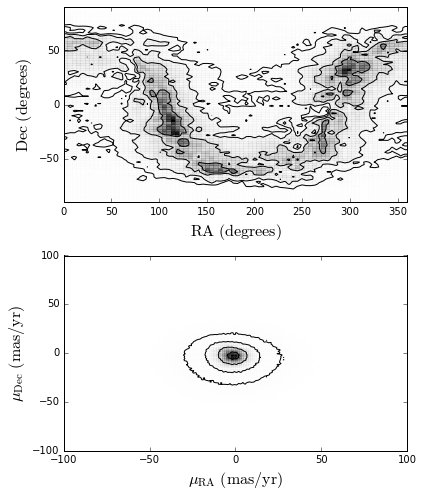

In [54]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':80}
corner.hist2d(t['ra'], t['dec'], range=[(0,360),(-90,90)], ax=ax[0], plot_datapoints=False, **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA\ (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec\ (degrees)}$', size=16)

contourf_kwargs = {'bins':80}
corner.hist2d(t['mu_ra'], t['mu_dec'], range=[(-50,50),(-50,50)], ax=ax[1], plot_datapoints=False, **contourf_kwargs)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)

plt.tight_layout()
plt.savefig('../figures/tycho-2_pos_mu.pdf')
#plt.show()

In [3]:


p_out = P_posterior.match_binaries(t)

Generating binaries...
We are testing 81227 stars...
0 4.66913604736
10 29.3583710194
20 103.236033916
30 122.944215059
40 136.557038069
50 153.231400967


KeyboardInterrupt: 

In [6]:
print "Opening Tycho-2 catalog..."
# Read in sample from Tycho-2 table
filename = ('../data/tycho-2/tyc2_00/tyc2.dat')
readme = ('../data/tycho-2/ReadMe')
tycho_full = Table.read(filename, format='cds', guess=False, readme=readme)
print "...finished reading data."


# Create the clean tycho-2 catalog
dtype = [('ID','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('Bmag','f8'),('Vmag','f8')]

ids = np.intersect1d(np.where(tycho_full['q_pmRA'] >= 0.1), np.where(tycho_full['q_pmDE'] >= 0.1))

t = np.zeros(len(ids), dtype=dtype)
t['ID'] = tycho_full['TYC1'][ids]*100000 + tycho_full['TYC2'][ids]
t['ra'] = tycho_full['RAmdeg'][ids]
t['dec'] = tycho_full['DEmdeg'][ids]
t['mu_ra'] = tycho_full['pmRA'][ids]
t['mu_dec'] = tycho_full['pmDE'][ids]
t['mu_ra_err'] = tycho_full['e_pmRA'][ids]
t['mu_dec_err'] = tycho_full['e_pmDE'][ids]
t['Bmag'] = tycho_full['BTmag'][ids]
t['Vmag'] = tycho_full['VTmag'][ids]



Opening Tycho-2 catalog...
...finished reading data.


In [3]:
# Read in the revised NLTT table
filename = ('../data/rNLTT/catalog_tabs.dat')
NLTT_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
NLTT_full['mu_ra'] = 1.0e3*NLTT_full['mu_ra']
NLTT_full['mu_dec'] = 1.0e3*NLTT_full['mu_dec']
NLTT_full['mu_ra_err'] = 1.0e3*NLTT_full['mu_ra_err']
NLTT_full['mu_dec_err'] = 1.0e3*NLTT_full['mu_dec_err']

# Select only systems with proper motion errors above 0.1 mas/yr
ids = np.intersect1d(np.where(NLTT_full['mu_ra_err'] >= 0.1), np.where(NLTT_full['mu_dec_err'] >= 0.1))

# Create the clean tycho-2 catalog
dtype = [('ID','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('B','f8'),('V','f8')]

t = np.zeros(len(ids), dtype=dtype)
t['ID'] = NLTT_full['NLTT'][ids]
t['ra'] = NLTT_full['ra'][ids]
t['dec'] = NLTT_full['dec'][ids]
t['mu_ra'] = NLTT_full['mu_ra'][ids]
t['mu_dec'] = NLTT_full['mu_dec'][ids]
t['mu_ra_err'] = NLTT_full['mu_ra_err'][ids]
t['mu_dec_err'] = NLTT_full['mu_dec_err'][ids]
t['B'] = NLTT_full['B'][ids]
t['V'] = NLTT_full['V'][ids]

In [4]:
p_out = P_posterior.match_binaries(t)

Generating binaries...
We are testing 35882 stars...
0 4.88287997246
10 6.46197509766
20 8.16448807716
30 9.91909599304
40 11.2673909664
44 45 77 77 [  1.95317624e-13] 0.0140880308933 [ 1.]
50 44.9666409492
50 52 84 86 [  1.41998612e-10] 5.96316216026e-05 [ 0.99999524]
60 89.0379910469
70 90.4046990871
80 92.0078499317
90 93.313131094
99 100 158 159 [ 0.] 0.00583996933504 [ 1.]
100 133.400747061


KeyboardInterrupt: 

In [13]:
print t.colnames

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'V', 'B', 'R', 'J', 'H', 'K']
